# About Dataset
This data approach student achievement in secondary education of two Portuguese schools. The data attributes include student grades, demographic, social, and school-related features, and it was collected by using school reports and questionnaires. Two datasets are provided regarding the performance in two distinct subjects: Mathematics (mat) and Portuguese language (por).

## Source
Paulo Cortez, University of Minho, Guimarães, Portugal, [http://www3.dsi.uminho.pt/pcortez](http://www3.dsi.uminho.pt/pcortez)

# Attributes
## Attributes for both Math and Portuguese language course datasets
1. **id** - unique record id matching one student (numeric)
2. **school** - student's school (binary: "GP" - Gabriel Pereira or "MS" - Mousinho da Silveira)
3. **sex** - student's sex (binary: "F" - female or "M" - male)
4. **age** - student's age (numeric: from 15 to 22)
5. **address** - student's home address type (binary: "U" - urban or "R" - rural)
6. **famsize** - family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
7. **Pstatus** - parent's cohabitation status (binary: "T" - living together or "A" - apart)
8. **Medu** - mother's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
9. **Fedu** - father's education (numeric: 0 - none, 1 - primary education (4th grade), 2 – 5th to 9th grade, 3 – secondary education or 4 – higher education)
10. **Mjob** - mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
11. **Fjob** - father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
12. **reason** - reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
13. **guardian** - student's guardian (nominal: "mother", "father" or "other")
14. **traveltime** - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
15. **studytime** - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
16. **failures** - number of past class failures (numeric: n if 1<=n<3, else 4)
17. **schoolsup** - extra educational support (binary: yes or no)
18. **famsup** - family educational support (binary: yes or no)
19. **paid** - extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
20. **activities** - extra-curricular activities (binary: yes or no)
21. **nursery** - attended nursery school (binary: yes or no)
22. **higher** - wants to take higher education (binary: yes or no)
23. **internet** - Internet access at home (binary: yes or no)
24. **romantic** - with a romantic relationship (binary: yes or no)
25. **famrel** - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
26. **freetime** - free time after school (numeric: from 1 - very low to 5 - very high)
27. **goout** - going out with friends (numeric: from 1 - very low to 5 - very high)
28. **Dalc** - workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
29. **Walc** - weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
30. **health** - current health status (numeric: from 1 - very bad to 5 - very good)
31. **absences** - number of school absences (numeric: from 0 to 93)

## Grades (targets)
These grades are related to the course subject, Math or Portuguese:
- **G1** - first period grade (numeric: from 0 to 20)
- **G2** - second period grade (numeric: from 0 to 20)
- **G3** - final grade (numeric: from 0 to 20, output target)


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from scipy.stats import skew

from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

import xgboost as xgb

from yellowbrick.model_selection import ValidationCurve

## 1.0 Loading the Data
The first row and column were manually removed from the .xlsx file in order for the .read_excel function to load data properly

In [2]:
path = "../data/student_performance.xlsx"
df = pd.read_excel(path)

## 2.1 Exploratory Data Analysys

In [3]:
df

,id,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,56,GP,F,15.0,U,GT3,A,4.0,3.0,services,...,4.0,3,2.0,1.0,1.0,1.0,0.0,15,14,15
1,192,GP,M,16.0,R,GT3,T,4.0,2.0,teacher,...,4.0,3,3.0,3.0,4.0,3.0,8.0,10,9,11
2,494,MS,F,16.0,R,LE3,T,1.0,2.0,at_home,...,4.0,4,5.0,1.0,3.0,3.0,0.0,8,9,9
3,404,GP,F,17.0,U,GT3,T,2.0,1.0,services,...,4.0,3,5.0,2.0,4.0,4.0,4.0,12,16,16
4,355,GP,F,17.0,U,GT3,T,2.0,3.0,other,...,4.0,2,1.0,1.0,1.0,3.0,2.0,11,12,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,387,GP,M,18.0,U,GT3,T,2.0,2.0,other,...,5.0,4,NaN,1.0,2.0,5.0,6.0,15,14,15
710,407,GP,F,21.0,U,LE3,T,4.0,4.0,other,...,3.0,3,2.0,1.0,1.0,5.0,0.0,9,12,12
711,473,MS,M,16.0,U,LE3,T,2.0,1.0,at_home,...,2.0,4,3.0,2.0,3.0,4.0,4.0,10,8,10
712,20,GP,M,15.0,U,GT3,T,4.0,3.0,teacher,...,4.0,4,1.0,1.0,1.0,1.0,0.0,12,13,14


The data set has 714 observations and 34 features per observation

Firstly lets drop the id column since a unique record id doesn't provide us with any extra information and remove any duplicates

In [4]:
df = df.drop("id", axis=1)
df = df.drop_duplicates()
df.shape

(649, 33)

Now our dataset contains 649 unique observations and 33 features

Next we will look at the missing values of the dataset

In [5]:
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

age           4
address       2
famsize       5
Pstatus       5
Medu          5
Fedu          5
Mjob          1
Fjob          3
reason        4
guardian      3
traveltime    2
studytime     3
failures      3
schoolsup     2
famsup        2
paid          4
activities    7
nursery       5
higher        2
internet      4
romantic      4
famrel        4
goout         4
Dalc          8
Walc          2
health        3
absences      4
dtype: int64

We can see that quite a few columns have missing values, on the other hand there are not a lot of them ~1% at most per column, we will deal with these missing values later on 

Next we can look at the types

In [6]:
df.dtypes

school         object
sex            object
age           float64
address        object
famsize        object
Pstatus        object
Medu          float64
Fedu          float64
Mjob           object
Fjob           object
reason         object
guardian       object
traveltime    float64
studytime     float64
failures      float64
schoolsup      object
famsup         object
paid           object
activities     object
nursery        object
higher         object
internet       object
romantic       object
famrel        float64
freetime        int64
goout         float64
Dalc          float64
Walc          float64
health        float64
absences      float64
G1              int64
G2              int64
G3              int64
dtype: object

We will firstly explore the **categorical columns** - those which have a dtype of 'object'  
We are going to list them out along with their unique values in order to later decide how can we transform them to fit our models needs

In [7]:
categorical_columns = df.select_dtypes(include=["object"]).columns

for col in categorical_columns:
    # Omit the NaN values
    print(f"{col}: {df[df[col].notnull()][col].unique()}") 

school: ['GP' 'MS']
sex: ['F' 'M']
address: ['U' 'R']
famsize: ['GT3' 'LE3']
Pstatus: ['A' 'T']
Mjob: ['services' 'teacher' 'at_home' 'other' 'health']
Fjob: ['services' 'other' 'health' 'teacher' 'at_home']
reason: ['reputation' 'other' 'course' 'home']
guardian: ['mother' 'father' 'other']
schoolsup: ['no' 'yes' 'não' '0' 'sim']
famsup: ['yes' 'no' 'não' '1' 'sim' '0']
paid: ['no' '0' 'yes' 'não' 'sim']
activities: ['yes' 'no' 'não' '1' '0' 'sim']
nursery: ['yes' 'no' 'não' 'sim' '1']
higher: ['yes' 'no' '1' 'sim' 'não']
internet: ['yes' 'no' 'sim' '1' '0']
romantic: ['no' 'yes' '0' 'não' 'sim' '1']


Some of the "binary" columns seem to be inconsistent - they contain english/portugees words corresponding to true and false along with 0's and 1's
There are other columns, which only take 2 unique values that can be interpreted as "binary"  
And finally several that take more than 2 unqiue values, we will discuss how to represent these in the preprocessing step

For the sake of visualizations, we will fix the inconsistent columns

In [8]:
transformation_dict = {
    "yes": "yes", "1": "yes", "sim": "yes",
    "no": "no", "0": "no", "não": "no"
}

inconsistent_columns = ["schoolsup", "famsup", "paid", "activities", "nursery", "higher", "internet", "romantic"]
df[inconsistent_columns] = df[inconsistent_columns].apply(lambda col: col.map(transformation_dict))

Now we can visualize these columns, starting with those which have only two unique values

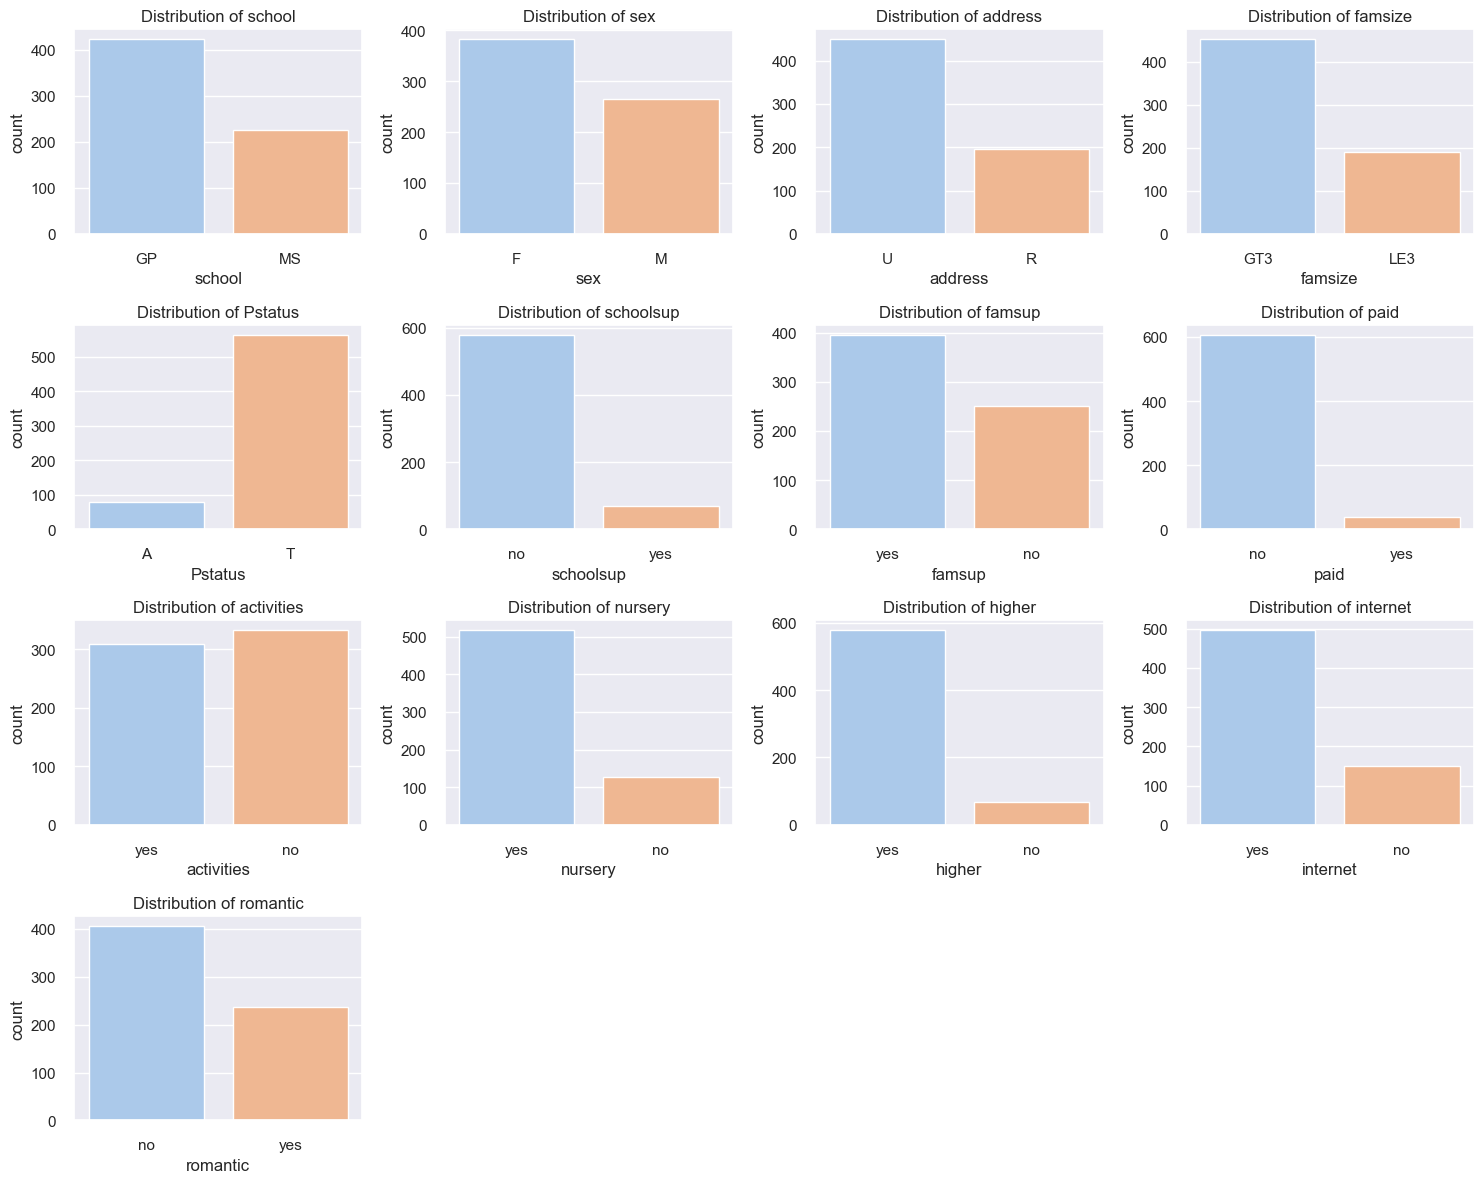

In [9]:
sns.set()
sns.set_palette("pastel")
index = 1

plt.figure(figsize=(15, 12))
for col in df[categorical_columns]:
    column = df[df[col].notnull()][col]
    if len(column.unique()) == 2:
        plt.subplot(4, 4, index)
        sns.countplot(data=df, x=col, legend=False, hue=col)
        plt.title(f"Distribution of {col}")
        
        index += 1

plt.tight_layout()
plt.show()

We can see that some of the columns such as 'activities' are balanced and other like 'Pstatus', 'higher' ... are tipped to one side

Lets also visualize the categorical columns, which have more than 2 unique values

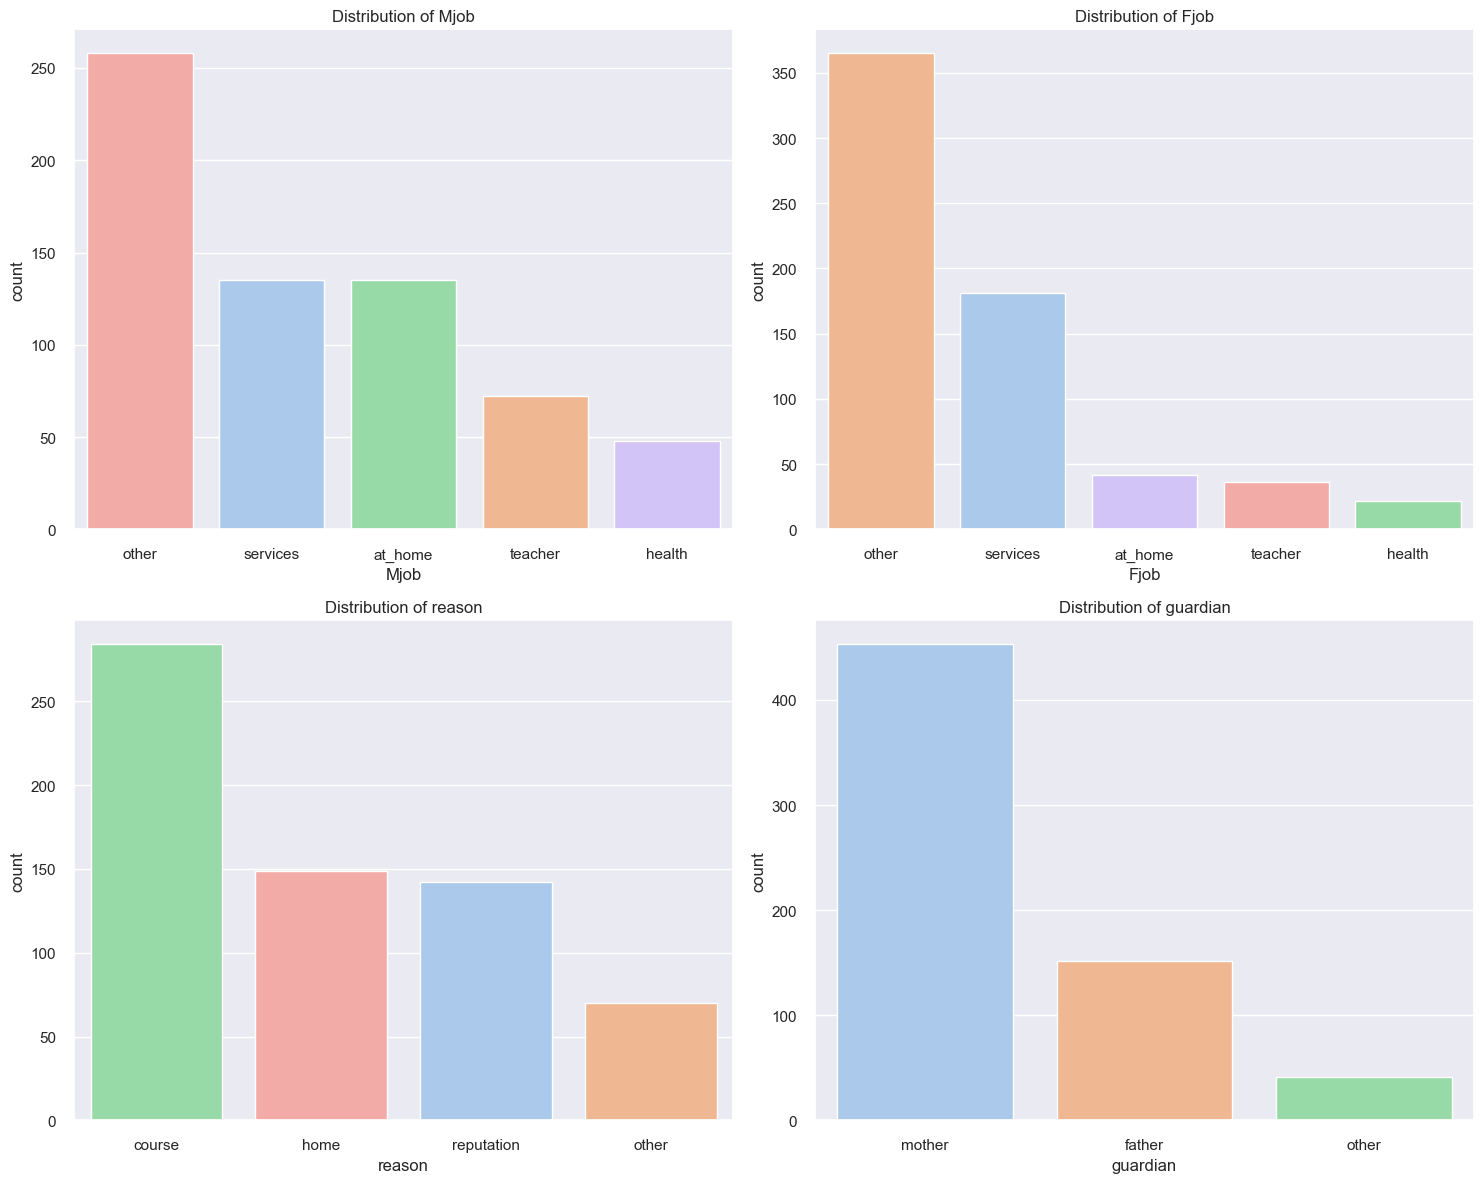

In [10]:
index = 1

plt.figure(figsize=(15, 12))
for col in df[categorical_columns]:
    column = df[df[col].notnull()][col]
    if len(column.unique()) > 2:
        order = column.value_counts().index
        plt.subplot(2, 2, index)
        sns.countplot(data=df, x=col, legend=False, order=order, hue=col)
        plt.title(f"Distribution of {col}")
        
        index += 1

plt.tight_layout()
plt.show()

Here are some interesting insights:
- The majority of the students' mothers are either staying at home or working in service jobs.
- Most of the students' fathers work in service jobs.
- The primary reason for choosing a particular school is course preference.
- The student's guardian is most commonly his mother.

Next, we will take a closer look at **numeric columns**, starting with a basic summary  
We won't consider the id column, since it has no information value for us

In [11]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns
target_columns = ["G1", "G2","G3"]
df[numeric_columns].describe().T

,count,mean,std,min,25%,50%,75%,max
age,645.0,16.739535,1.219817,15.0,16.0,17.0,18.0,22.0
Medu,644.0,2.510870,1.132665,0.0,2.0,2.0,4.0,4.0
Fedu,644.0,2.310559,1.101313,0.0,1.0,2.0,3.0,4.0
traveltime,647.0,1.568779,0.749292,1.0,1.0,1.0,2.0,4.0
studytime,646.0,1.934985,0.828999,1.0,1.0,2.0,2.0,4.0
failures,646.0,0.222910,0.594420,0.0,0.0,0.0,0.0,3.0
famrel,645.0,3.928682,0.957740,1.0,4.0,4.0,5.0,5.0
freetime,649.0,3.180277,1.051093,1.0,3.0,3.0,4.0,5.0
goout,645.0,3.187597,1.177098,1.0,2.0,3.0,4.0,5.0
Dalc,641.0,1.497660,0.922163,1.0,1.0,1.0,2.0,5.0


Some interesting obervations are
- Failures varianble is highly imbalanced with most students having 0 failures
- Target variables G1, G2 and G2 exhibit similar values

We can also look at the distributions

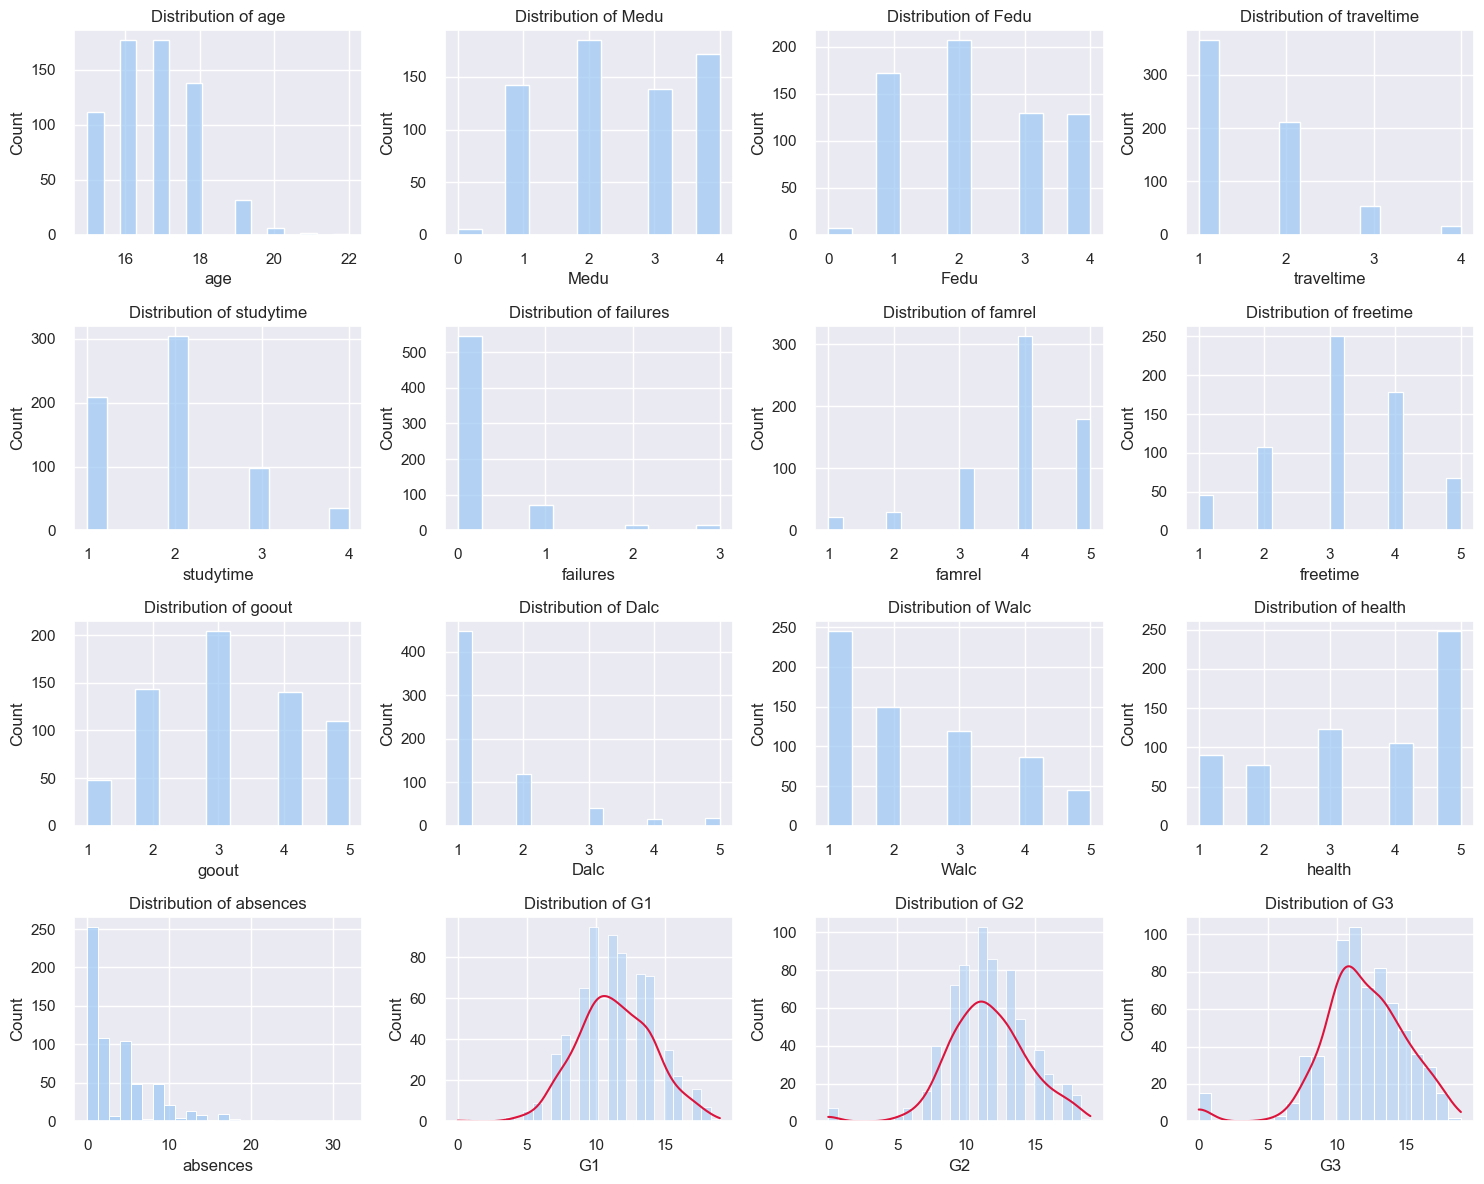

In [12]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    if col not in target_columns:
        sns.histplot(data=df, x=col)
    else:
        ax = sns.histplot(data=df, x=col, kde=True)
        ax.lines[0].set_color('crimson')
    plt.title(f"Distribution of {col}")
    
plt.tight_layout()
plt.show()

We can also visualize the distributions using boxplots

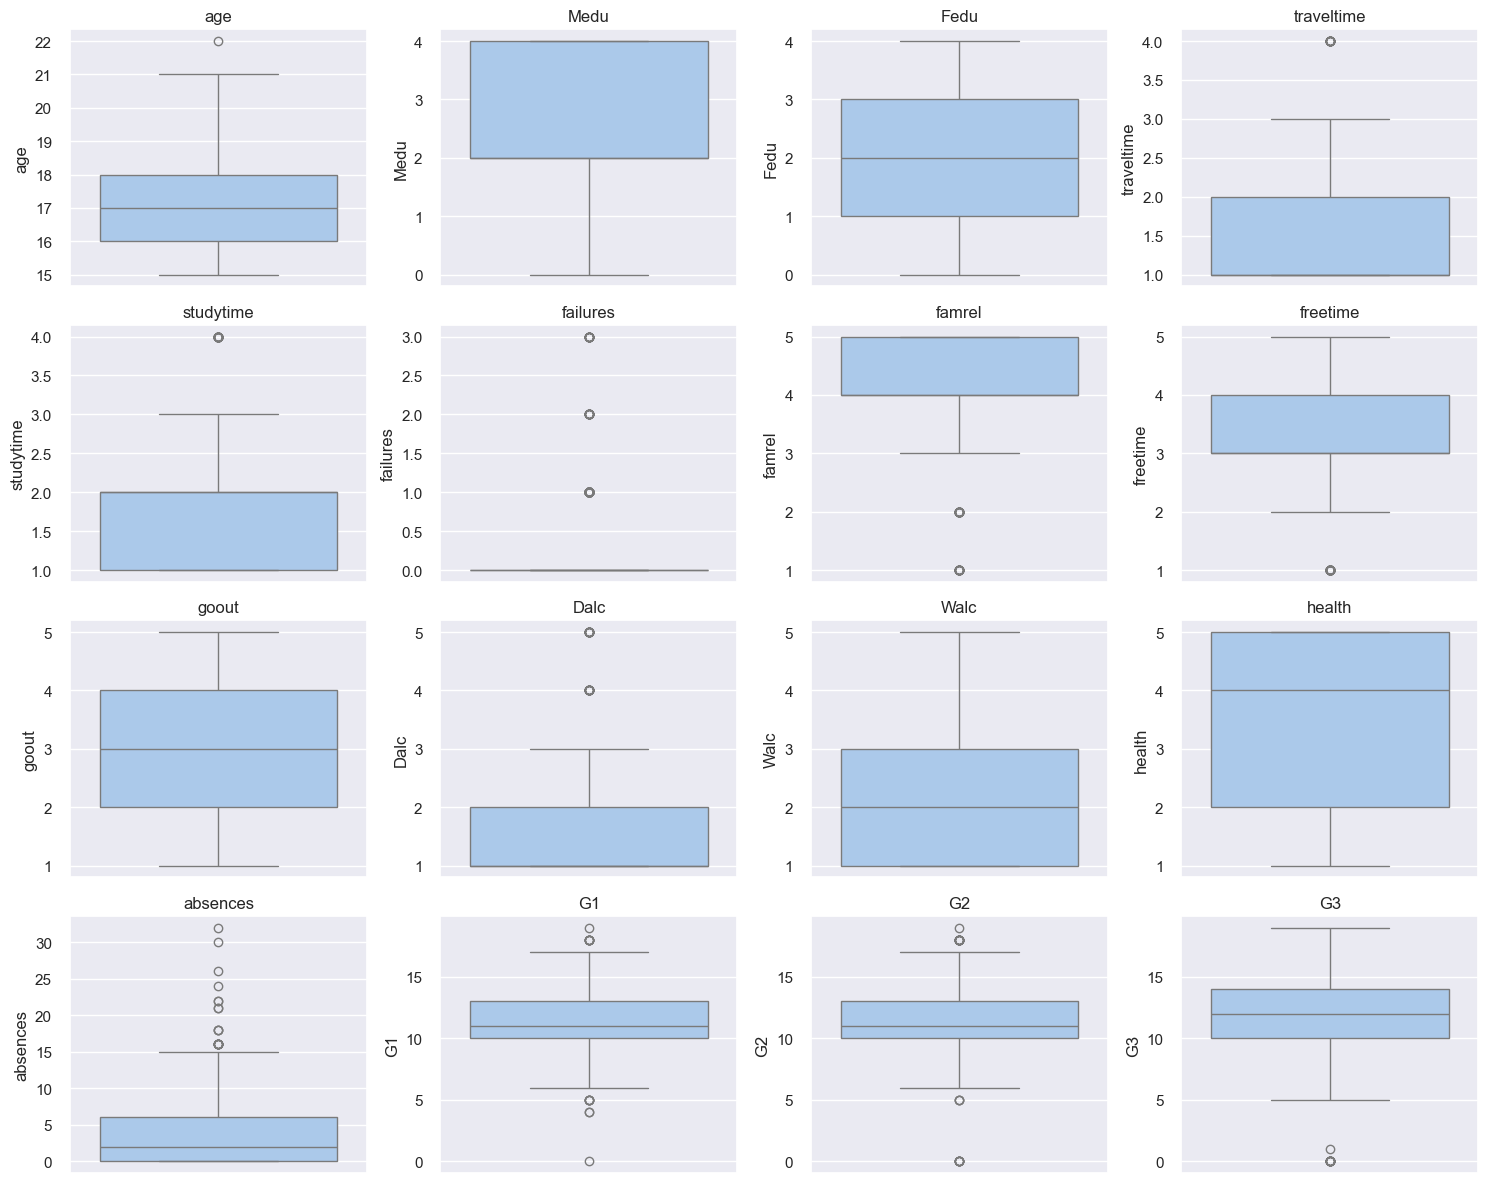

In [13]:
plt.figure(figsize=(15, 12))

for i, col in enumerate(numeric_columns, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(data=df, y=col)
    plt.title(f"{col}")
    
plt.tight_layout()
plt.show()

We will also look at linear relationships using a correlation heatmap

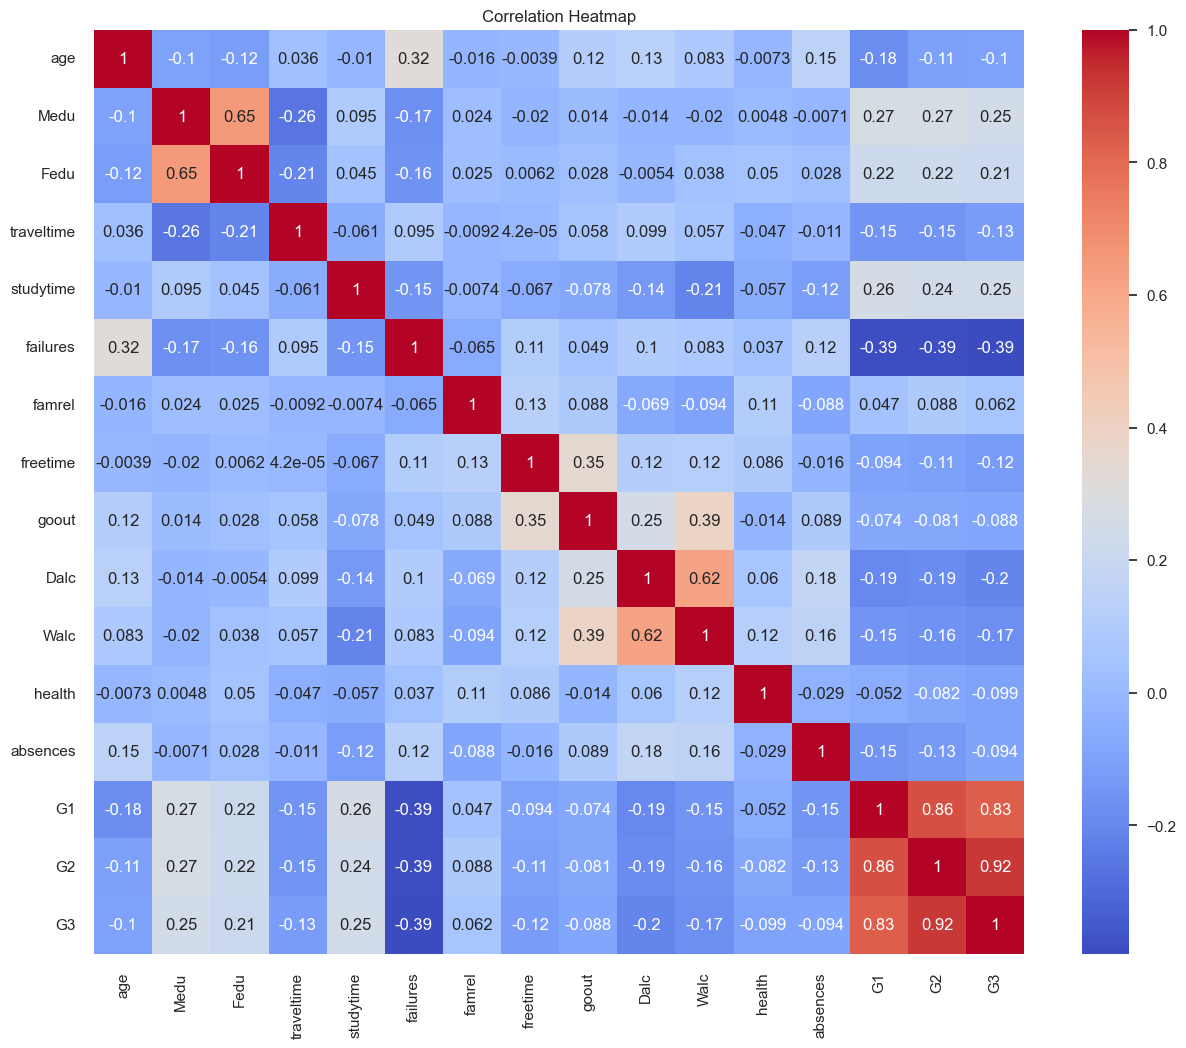

In [14]:
correlation_matrix = df[numeric_columns].corr()

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

Target variables G1, G2 and G3 have a strong positive correlation  
Variables describing the workday and weekend alcohol consumption also exhibit a positive correlation, this also applies to father's and mother's education

The strongest negative correlation is between the grades and the number of failures, meaning that people who fail are more likely to get a worst grade

## 2.2 Preprocessing

In [68]:
# Checkpoint to reset preprocessing
df = pd.read_excel("../data/unprocessed.xlsx")
assert df.shape == (649, 33)

As our first preprocessing step, we will change the dtype from 'object' to 'category'

In [69]:
for col in categorical_columns:
    df[col] = df[col].astype("category")
    
df[categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      649 non-null    category
 1   sex         649 non-null    category
 2   address     647 non-null    category
 3   famsize     644 non-null    category
 4   Pstatus     644 non-null    category
 5   Mjob        648 non-null    category
 6   Fjob        646 non-null    category
 7   reason      645 non-null    category
 8   guardian    646 non-null    category
 9   schoolsup   647 non-null    category
 10  famsup      647 non-null    category
 11  paid        645 non-null    category
 12  activities  642 non-null    category
 13  nursery     644 non-null    category
 14  higher      647 non-null    category
 15  internet    645 non-null    category
 16  romantic    645 non-null    category
dtypes: category(17)
memory usage: 13.2 KB


### Missing Values

For categorical data, we will use SimpleImputer with "most frequent" strategy

In [70]:
simple_imputer = SimpleImputer(strategy="most_frequent")

for col in categorical_columns:
    df[[col]] = simple_imputer.fit_transform(df[[col]])

For numeric variables, since there are not a lot of missing data IterativeImputer would be the best choice

In [71]:
iterative_imputer = IterativeImputer()

for col in numeric_columns:
    df[[col]] = iterative_imputer.fit_transform(df[[col]])
    
# Check that there are no more missing values in our dataset
missing_values = df.isnull().sum()
assert len(missing_values[missing_values > 0]) == 0

### Encoding

We will use a LabelEncoder for "binary" columns

In [72]:
label_encoder = LabelEncoder()
binary_columns = [col for col in categorical_columns if len(df[df[col].notnull()][col].unique()) == 2]

for col in binary_columns:
    df[col] = label_encoder.fit_transform(df[col])
    
df[binary_columns].head()

,school,sex,address,famsize,Pstatus,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
0,0,0,1,0,0,0,1,0,1,1,1,1,0
1,0,1,0,0,1,0,1,0,1,1,1,1,1
2,1,0,0,1,1,0,0,0,1,1,0,1,0
3,0,0,1,0,1,0,1,0,1,1,1,1,0
4,0,0,1,0,1,0,0,0,1,1,1,1,1


And OneHotEncoder for columns that have more than 2 unique values

In [73]:
one_hot_encoder = OneHotEncoder(sparse_output=False)
nonbinary_columns = [col for col in categorical_columns if col not in binary_columns]

one_hot_encoded_data = one_hot_encoder.fit_transform(df[nonbinary_columns])
one_hot_encoded_columns = one_hot_encoder.get_feature_names_out(nonbinary_columns)

# Create a df from the encoded data and columns
one_hot_encoded_df = pd.DataFrame(one_hot_encoded_data, columns=one_hot_encoded_columns)

# Transform the original df
df = pd.concat([df.drop(columns=nonbinary_columns), one_hot_encoded_df], axis=1)

In [74]:
df.shape

(649, 46)

We have transformed the original 4 "nonbinary" categorical columns to 17 new encoded ones

### Scaling the Data

Lets continue with scaling our data, we will use a Standard Scaler

In [75]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

### Splitting the Data

In [76]:
X, y = df.drop(columns=["G1", "G2", "G3"]), df["G3"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train shape: {X_train.shape} {y_train.shape}")
print(f"Test  shape: {X_test.shape} {y_test.shape}")

Train shape: (519, 43) (519,)
Test  shape: (130, 43) (130,)


### Feature Selection

We will use Ridge Regression model for Feature Selection and perform selection of k-best features. We will use two different score functions:
- correlation feature selection using f_regression
- mutual information feature selection (typically used in the construction of decision trees)

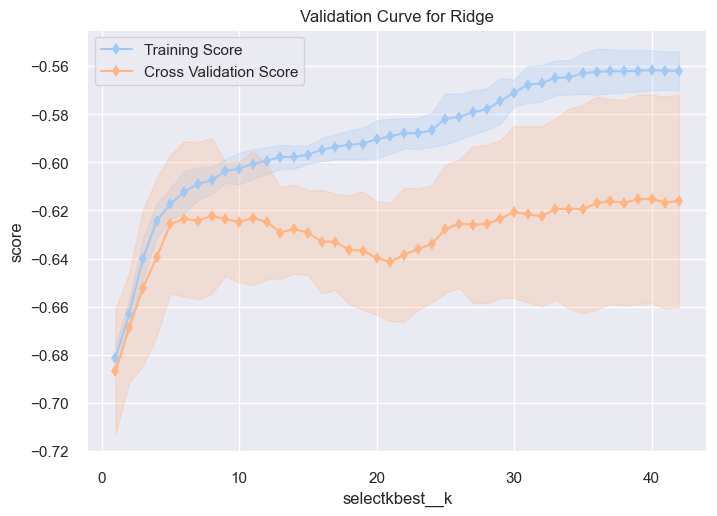

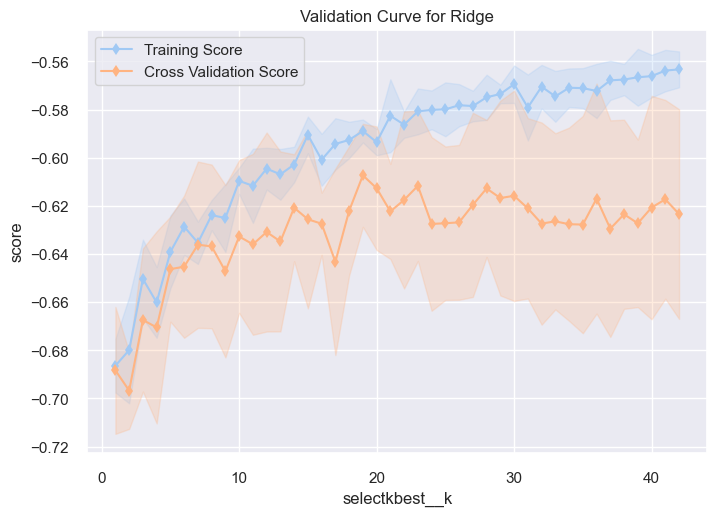

In [77]:
for score_func in [f_regression, mutual_info_regression]:
    
    kbest_pipeline = make_pipeline(
        SelectKBest(score_func=score_func),
        Ridge()
    )
    
    viz = ValidationCurve(
        kbest_pipeline,
        param_name="selectkbest__k",
        param_range=np.arange(1, 43),
        cv=5,
        scoring="neg_mean_absolute_error",
    )
    
    viz.fit(X_train, y_train)
    viz.show()
    plt.show()

In [78]:
selector = SelectKBest(k=20)
selector.fit(X_train, y_train)

mask = selector.get_support()
selected_features = X_train.columns[mask]

X_train = pd.DataFrame(selector.transform(X_train), columns=selected_features, index=X_train.index)
X_test = pd.DataFrame(selector.transform(X_test), columns=selected_features, index=X_test.index)

### Baseline Model

In [79]:
for strategy in ["mean", "median"]:
    dummy_regr = DummyRegressor(strategy=strategy)
    dummy_regr.fit(X_train, y_train)
    dummy_pred = dummy_regr.predict(X_test)
    print(f"RMSE using strategy {strategy}: {root_mean_squared_error(y_test, dummy_pred):.3f}")

RMSE using strategy mean: 1.029
RMSE using strategy median: 1.029


## XGBoost Regressor

exaplain...

Converting data into DMatrix, which is optimized for XGBoost

In [80]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

#### First Run

In [81]:
params = {
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
    "seed": 42
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=100,
    evals=[(dtrain, "train"), (dtest, "test")],
    verbose_eval=10
)

y_pred = model.predict(dtest)

print("\nModel Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"R2: {r2_score(y_test, y_pred):.4f}")

[0]	train-rmse:0.84850	test-rmse:0.97515
[10]	train-rmse:0.44508	test-rmse:1.02247
[20]	train-rmse:0.31284	test-rmse:1.06540
[30]	train-rmse:0.23896	test-rmse:1.07158
[40]	train-rmse:0.18993	test-rmse:1.09163
[50]	train-rmse:0.15721	test-rmse:1.09511
[60]	train-rmse:0.12932	test-rmse:1.10103
[70]	train-rmse:0.10416	test-rmse:1.10231
[80]	train-rmse:0.08632	test-rmse:1.10813
[90]	train-rmse:0.07027	test-rmse:1.10968
[99]	train-rmse:0.05854	test-rmse:1.11066

Model Evaluation:
RMSE: 1.1107
MAE: 0.7293
R2: -0.1649


#### Hyperparameter Tuning

In [82]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 6, 9],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 0.9, 1.0],
    "colsample_bytree": [0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.2]
}

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred_tuned = best_model.predict(X_test)
print("\nTuned Model Evaluation:")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_tuned)):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_tuned):.4f}")
print(f"R2: {r2_score(y_test, y_pred_tuned):.4f}")

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best parameters found:
{'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}

Tuned Model Evaluation:
RMSE: 0.9845
MAE: 0.6619
R2: 0.0848


#### Feature Importance

<Figure size 1000x600 with 0 Axes>

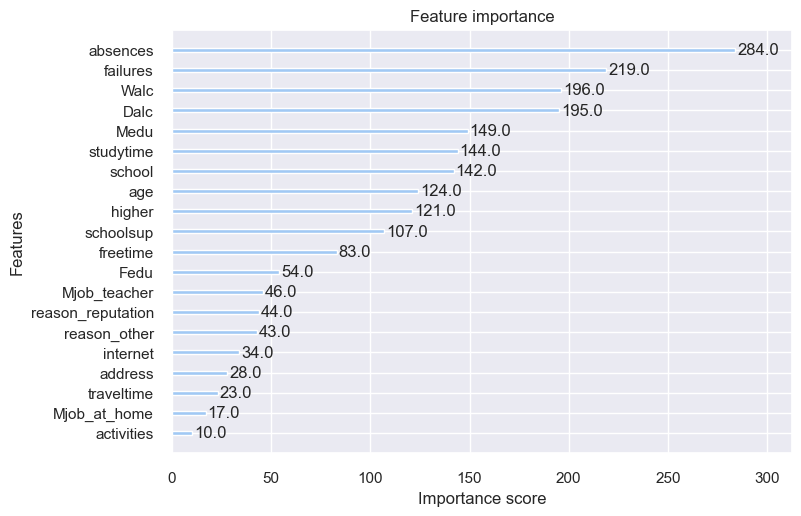

In [83]:
plt.figure(figsize=(10, 6))
xgb.plot_importance(best_model.get_booster(), importance_type="weight")
plt.show()

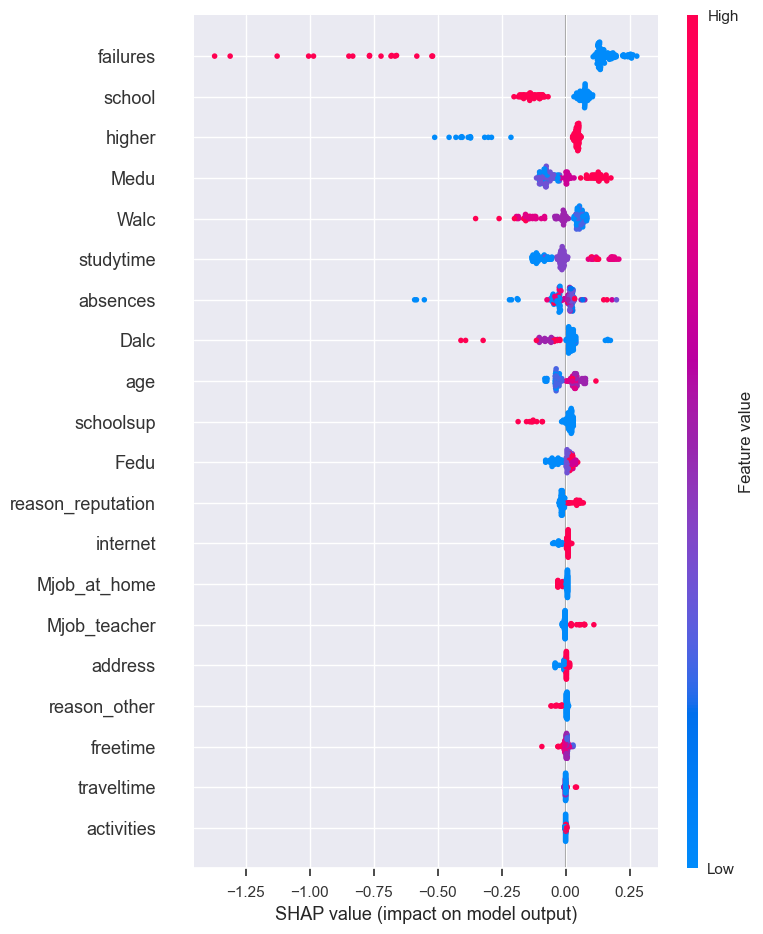

In [91]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.show()

#### Learning Curve

[0]	train-rmse:0.98908	test-rmse:1.02729
[10]	train-rmse:0.95894	test-rmse:1.01029
[20]	train-rmse:0.93395	test-rmse:0.99794
[30]	train-rmse:0.91038	test-rmse:0.98810
[40]	train-rmse:0.88723	test-rmse:0.98061
[50]	train-rmse:0.86798	test-rmse:0.97532
[60]	train-rmse:0.85065	test-rmse:0.97071
[70]	train-rmse:0.83562	test-rmse:0.96642
[80]	train-rmse:0.82157	test-rmse:0.96391
[90]	train-rmse:0.80895	test-rmse:0.96192
[100]	train-rmse:0.79649	test-rmse:0.96326
[110]	train-rmse:0.78618	test-rmse:0.96147
[120]	train-rmse:0.77638	test-rmse:0.96266
[130]	train-rmse:0.76750	test-rmse:0.96325
[140]	train-rmse:0.75877	test-rmse:0.96682
[150]	train-rmse:0.75129	test-rmse:0.96893
[160]	train-rmse:0.74436	test-rmse:0.97188


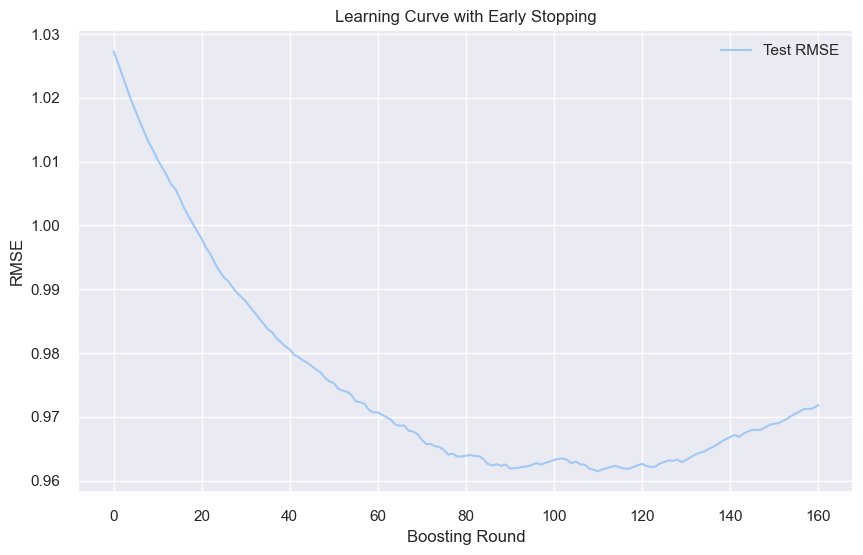

Stopped at iteration 110 with best score 0.9615


In [99]:
grid_search.best_params_.pop("n_estimators", None)

evals_result = {}
model_early_stop = xgb.train(
    grid_search.best_params_,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, "train"), (dtest, "test")],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=10
)

results = evals_result["test"]["rmse"]
plt.figure(figsize=(10, 6))
plt.plot(results, label="Test RMSE")
plt.xlabel("Boosting Round")
plt.ylabel("RMSE")
plt.title("Learning Curve with Early Stopping")
plt.legend()
plt.show()

print(f"Stopped at iteration {model_early_stop.best_iteration} with best score {model_early_stop.best_score:.4f}")